In [1]:
# --- Importation des Bibliothèques ---

# Manipulation des données
import pandas as pd  # Pour la manipulation des données tabulaires
import numpy as np  # Pour les calculs numériques

# Gestion des fichiers et des répertoires
import os  # Pour interagir avec le système de fichiers
from pathlib import Path  # Pour gérer les chemins de fichiers et répertoires
import sys  # Pour modifier le chemin d'import des modules

# Gestion des logs
from loguru import logger  # Pour gérer les logs enrichis

# Résumés statistiques
from skimpy import skim  # Résumés enrichis pour les DataFrames

# Suppression des avertissements inutiles
import warnings  # Pour ignorer les warnings
warnings.filterwarnings("ignore")

# Visualisation des données
import matplotlib.pyplot as plt  # Visualisations statiques simples
import seaborn as sns  # Visualisations statistiques avancées
import plotly.express as px  # Visualisations interactives rapides
import plotly.graph_objects as go  # Graphiques interactifs personnalisés
from plotly.subplots import make_subplots  # Pour combiner plusieurs graphiques interactifs
 
# Analyse statistique
from scipy.stats import gaussian_kde  # Estimation de la densité des probabilités
from scipy.stats.mstats import winsorize  # Pour limiter les outliers
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer 

# Configuration des affichages pandas
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes d'un DataFrame
pd.set_option('display.max_rows', 150)  # Afficher jusqu'à 150 lignes d'un DataFrame
pd.set_option('display.width', 300)  # Éviter les retours à la ligne inutiles

# --- Configuration des Logs ---
# Définir le fichier pour enregistrer les logs avec rotation automatique
logger.add("../logs/analyse.log", rotation="500 MB")
logger.info("=" * 60)
logger.info("Démarrage du notebook")
logger.info("=" * 60)
# --- Définir le répertoire de travail ---
NOTEBOOK_PATH = Path(os.getcwd())  # Chemin actuel
if NOTEBOOK_PATH.name == "notebooks":
    BASE_DIR = NOTEBOOK_PATH.parent
else:
    BASE_DIR = NOTEBOOK_PATH

# Ajouter le répertoire 'src' au chemin Python
sys.path.append(str(BASE_DIR / "src"))

# Définir les répertoires pour les données brutes, nettoyées et les scripts
RAW_DIR = BASE_DIR / "data/raw"
PROCESSED_DIR = BASE_DIR / "data/processed"
SCRIPTS_DIR = BASE_DIR / "scripts"
OUTPUTS_DIR = BASE_DIR / "outputs"


# --- Fonction pour configurer les répertoires ---
def setup_and_log_directories(base_dir, raw_dir, processed_dir, scripts_dir, outputs_dir):
    """
    Configure les répertoires nécessaires au projet.
    Crée les répertoires s'ils n'existent pas et logue leur état.

    Args:
        base_dir (Path): Répertoire racine.
        raw_dir (Path): Répertoire des fichiers bruts.
        processed_dir (Path): Répertoire des fichiers nettoyés.
        scripts_dir (Path): Répertoire des scripts.
        outputs_dir (Path): Répertoire des outputs.

    Returns:
        dict: Dictionnaire contenant les chemins relatifs et absolus.
    """
    try:
        # Définir les chemins relatifs
        base_dir_relative = base_dir.name
        raw_dir_relative = raw_dir.relative_to(base_dir)
        processed_dir_relative = processed_dir.relative_to(base_dir)
        scripts_dir_relative = scripts_dir.relative_to(base_dir)
        outputs_dir_relative = outputs_dir.relative_to(base_dir)
        
        # Loguer le répertoire racine
        logger.info(f"Répertoire racine configuré : {base_dir_relative}")

        # Vérifier et créer les répertoires si nécessaire
        raw_dir.mkdir(parents=True, exist_ok=True)
        logger.info(f"Répertoire des fichiers bruts configuré : {base_dir_relative}\\{raw_dir_relative}")

        processed_dir.mkdir(parents=True, exist_ok=True)
        logger.info(f"Répertoire des fichiers nettoyés configuré : {base_dir_relative}\\{processed_dir_relative}")

        scripts_dir.mkdir(parents=True, exist_ok=True)
        logger.info(f"Répertoire des scripts configuré : {base_dir_relative}\\{scripts_dir_relative}")

        outputs_dir.mkdir(parents=True, exist_ok=True)
        logger.info(f"Répertoire des scripts configuré : {base_dir_relative}\\{outputs_dir_relative}")

        # Retourner les chemins relatifs et absolus
        return {
            "base_dir": base_dir,
            "raw_dir": {"absolute": raw_dir, "relative": raw_dir_relative},
            "processed_dir": {"absolute": processed_dir, "relative": processed_dir_relative},
            "scripts_dir": {"absolute": scripts_dir, "relative": scripts_dir_relative},
            "outputs_dir": {"absolute": outputs_dir, "relative": outputs_dir_relative}
        }

    except Exception as e:
        logger.error(f"Erreur lors de la configuration des répertoires : {e}")
        raise

# Configuration des répertoires
directories = setup_and_log_directories(BASE_DIR, RAW_DIR, PROCESSED_DIR, SCRIPTS_DIR, OUTPUTS_DIR)
logger.info("=" * 60)
logger.info("Répertoires vérifiés et configurés avec succès.")
logger.info("=" * 60)

2025-01-31 15:51:13.503 | INFO     | __main__:<module>:43 - ============================================================
2025-01-31 15:51:13.504 | INFO     | __main__:<module>:44 - Démarrage du notebook
2025-01-31 15:51:13.505 | INFO     | __main__:<module>:45 - ============================================================
2025-01-31 15:51:13.506 | INFO     | __main__:setup_and_log_directories:88 - Répertoire racine configuré : consommation_energie_batiments
2025-01-31 15:51:13.507 | INFO     | __main__:setup_and_log_directories:92 - Répertoire des fichiers bruts configuré : consommation_energie_batiments\data\raw
2025-01-31 15:51:13.508 | INFO     | __main__:setup_and_log_directories:95 - Répertoire des fichiers nettoyés configuré : consommation_energie_batiments\data\processed
2025-01-31 15:51:13.509 | INFO     | __main__:setup_and_log_directories:98 - Répertoire des scripts configuré : consommation_energie_batiments\scripts
2025-01-31 15:51:13.510 | INFO     | __main__:setup_and_log_

In [2]:
# 🚀 Importation des DataFrames en CSV avec encodage UTF-8
logger.info("=" * 60)
logger.info("Début de l'importation du DataFrame en fichier CSV")
logger.info("-" * 10)

# --- Définir le chemin du fichier à charger ---
file_path = directories["raw_dir"]["absolute"]  # Chemin absolu vers le répertoire contenant les données brutes
dataset_file = file_path / "2016_Building_Energy_Benchmarking.csv"  # Fichier CSV à charger

try:
    # --- Chargement du fichier CSV dans un DataFrame pandas ---
    building_consumption = pd.read_csv(dataset_file, encoding="utf-8")  # Chargement avec encodage UTF-8
    logger.info(f"Fichier '{dataset_file.name}' chargé avec succès.")
    logger.info(f"Nombre de lignes : {building_consumption.shape[0]}. "
                f"Nombre de colonnes : {building_consumption.shape[1]}.")

except FileNotFoundError:
    # --- Gestion des erreurs : fichier manquant ---
    logger.error(f"Le fichier spécifié '{dataset_file.name}' est introuvable dans le dataset.")
    raise

except Exception as e:
    # --- Gestion des erreurs générales ---
    logger.error(f"Erreur lors du chargement du fichier '{dataset_file.name}' : {e}")
    raise

logger.info("-" * 10)
logger.info("Fin de l'importation du DataFrame en fichier CSV")
logger.info("=" * 60)

2025-01-31 15:51:13.518 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:13.520 | INFO     | __main__:<module>:3 - Début de l'importation du DataFrame en fichier CSV
2025-01-31 15:51:13.520 | INFO     | __main__:<module>:4 - ----------
2025-01-31 15:51:13.536 | INFO     | __main__:<module>:13 - Fichier '2016_Building_Energy_Benchmarking.csv' chargé avec succès.
2025-01-31 15:51:13.537 | INFO     | __main__:<module>:14 - Nombre de lignes : 3376. Nombre de colonnes : 46.
2025-01-31 15:51:13.538 | INFO     | __main__:<module>:27 - ----------
2025-01-31 15:51:13.539 | INFO     | __main__:<module>:28 - Fin de l'importation du DataFrame en fichier CSV
2025-01-31 15:51:13.539 | INFO     | __main__:<module>:29 - ============================================================


In [3]:
# --- Préparer les données pour la distribution des types de bâtiments ---
building_type_counts = building_consumption['BuildingType'].value_counts().reset_index()
building_type_counts.columns = ['BuildingType', 'count']  # Renommer les colonnes pour Plotly

# --- Créer un graphique interactif ---
fig_building_type = px.bar(
    building_type_counts,
    x='BuildingType',  # Axe X : Types de bâtiments
    y='count',          # Axe Y : Nombre de bâtiments
    title="Distribution des types de bâtiments",
    labels={'BuildingType': 'Type de bâtiment', 'count': 'Nombre de bâtiments'},
    template="plotly_white"
)
fig_building_type.update_traces(marker_color='blue')  # Couleur des barres
fig_building_type.show()  # Afficher le graphique
 
# --- Préparer les données pour la distribution des villes ---
city_counts = building_consumption['City'].value_counts().reset_index()
city_counts.columns = ['City', 'count']  # Renommer les colonnes pour Plotly

# --- Créer un graphique interactif ---
fig_city = px.bar(
    city_counts,
    x='City',  # Axe X : Villes
    y='count',  # Axe Y : Nombre de bâtiments
    title="Distribution des bâtiments par ville",
    labels={'City': 'Ville', 'count': 'Nombre de bâtiments'},
    template="plotly_white"
)
fig_city.update_traces(marker_color='green')  # Couleur des barres
fig_city.show()  # Afficher le graphique

In [4]:
# --- types de bâtiments non résidentiels ---
non_residential_types = [
    'NonResidential',
    'Nonresidential COS',
    'SPS-District K-12',
    'Campus',
    'Nonresidential WA'
]

# --- Appliquer le filtre sur les données ---
building_consumption = building_consumption[
    (building_consumption['BuildingType'].isin(non_residential_types)) &  # Filtrer par type de bâtiment
    (building_consumption['City'].str.lower() == 'seattle')  # Filtrer par ville (insensible à la casse)
]

# --- Afficher les dimensions du DataFrame après filtrage ---
logger.info(f"Dimensions après filtrage : {building_consumption.shape}")

2025-01-31 15:51:13.950 | INFO     | __main__:<module>:17 - Dimensions après filtrage : (1668, 46)


In [5]:
# Afficher les dimensions du dataset après filtrage
logger.info("=" * 60)
logger.info(f"Nombre de lignes : {building_consumption.shape[0]}")
logger.info(f"Nombre de colonnes : {building_consumption.shape[1]}")
logger.info("=" * 60)

2025-01-31 15:51:13.957 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:13.957 | INFO     | __main__:<module>:3 - Nombre de lignes : 1668
2025-01-31 15:51:13.958 | INFO     | __main__:<module>:4 - Nombre de colonnes : 46
2025-01-31 15:51:13.959 | INFO     | __main__:<module>:5 - ============================================================


In [6]:
logger.info("=" * 60)
# Afficher un aperçu des 5 premières lignes du dataset
logger.info("Aperçu des données :")
logger.info("=" * 60)
logger.info(f"\n {building_consumption.head()}")
logger.info("=" * 60)

2025-01-31 15:51:13.964 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:13.965 | INFO     | __main__:<module>:3 - Aperçu des données :
2025-01-31 15:51:13.965 | INFO     | __main__:<module>:4 - ============================================================
2025-01-31 15:51:13.973 | INFO     | __main__:<module>:5 - 
    OSEBuildingID  DataYear    BuildingType PrimaryPropertyType                 PropertyName          Address     City State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0              1      2016  NonResidential               Hotel         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0                    0659000030                    7     DOWNTOWN  47.61220 -122.33799       1927                1.0              12             88434   
1              2      2016  NonResidential       

In [7]:
# Vérification des types des colonnes
logger.info("=" * 60)
logger.info("📊 Types des colonnes pour le DataFrame 'building_consumption")
logger.info("=" * 60)

try:
    for col in building_consumption.columns:
        col_type = building_consumption[col].dtype  # Type de données pandas (int64, float64, object, etc.)
        unique_types = building_consumption[col].apply(lambda x: type(x).__name__).unique()
        logger.info(f"🔹 {col} : {col_type} | Types Python rencontrés : {', '.join(unique_types)}")
    logger.info("=" * 60)
    logger.info("📋 Types des colonnes inspectés avec succès.")
except Exception as e:
    logger.error(f"Erreur lors de l'inspection des types des colonnes : {e}")
    raise

logger.info("=" * 60)

# 🔍 Détection des colonnes numériques mal encodées en 'object'
wrong_types = building_consumption.select_dtypes(include=['object']).columns
if len(wrong_types) > 0:
    logger.warning(f"⚠️ Colonnes suspectes pouvant contenir des valeurs numériques : {list(wrong_types)}")

    # Vérification des valeurs uniques pour voir si elles sont mal typées
    for col in wrong_types:
        unique_values = building_consumption[col].unique()
        logger.info(f"🔹 {col} - {len(unique_values)} valeurs uniques : {unique_values[:5]} ...")
else:
    logger.info("✅ Aucune colonne suspecte trouvée parmi les types 'object'.")


2025-01-31 15:51:13.983 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:13.984 | INFO     | __main__:<module>:3 - 📊 Types des colonnes pour le DataFrame 'building_consumption
2025-01-31 15:51:13.985 | INFO     | __main__:<module>:4 - ============================================================
2025-01-31 15:51:13.987 | INFO     | __main__:<module>:10 - 🔹 OSEBuildingID : int64 | Types Python rencontrés : int
2025-01-31 15:51:13.988 | INFO     | __main__:<module>:10 - 🔹 DataYear : int64 | Types Python rencontrés : int
2025-01-31 15:51:13.988 | INFO     | __main__:<module>:10 - 🔹 BuildingType : object | Types Python rencontrés : str
2025-01-31 15:51:13.989 | INFO     | __main__:<module>:10 - 🔹 PrimaryPropertyType : object | Types Python rencontrés : str
2025-01-31 15:51:13.990 | INFO     | __main__:<module>:10 - 🔹 PropertyName : object | Types Python rencontrés : str
2025-01-31 15:51:13.991 | INFO     | __main__:<module>:10 

In [8]:
# Détection des valeurs aberrantes pour les variables numériques
numeric_columns = building_consumption.select_dtypes(include=[np.number]).columns
outliers = {}
for col in numeric_columns:
    q1 = building_consumption[col].quantile(0.25)
    q3 = building_consumption[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((building_consumption[col] < lower_bound) | (building_consumption[col] > upper_bound)).sum()
    if outlier_count > 0:
        outliers[col] = outlier_count
logger.info("=" * 60)
logger.info("🔍 Valeurs aberrantes détectées :")
logger.info("=" * 60)
for col, count in outliers.items():
    logger.info(f"📌 {col} : {count} valeurs aberrantes détectées")

# Vérification des erreurs typographiques pour les variables catégoriques
categorical_columns = building_consumption.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = building_consumption[col].nunique()
    logger.info(f"🔤 {col} contient {unique_values} valeurs uniques")
    if unique_values < 10:  # Seuil arbitraire pour l'affichage
        logger.info(f"Valeurs uniques dans {col} : {building_consumption[col].unique()}")

2025-01-31 15:51:14.065 | INFO     | __main__:<module>:13 - ============================================================
2025-01-31 15:51:14.065 | INFO     | __main__:<module>:14 - 🔍 Valeurs aberrantes détectées :
2025-01-31 15:51:14.066 | INFO     | __main__:<module>:15 - ============================================================
2025-01-31 15:51:14.067 | INFO     | __main__:<module>:17 - 📌 ZipCode : 51 valeurs aberrantes détectées
2025-01-31 15:51:14.067 | INFO     | __main__:<module>:17 - 📌 Longitude : 199 valeurs aberrantes détectées
2025-01-31 15:51:14.068 | INFO     | __main__:<module>:17 - 📌 NumberofBuildings : 105 valeurs aberrantes détectées
2025-01-31 15:51:14.068 | INFO     | __main__:<module>:17 - 📌 NumberofFloors : 138 valeurs aberrantes détectées
2025-01-31 15:51:14.069 | INFO     | __main__:<module>:17 - 📌 PropertyGFATotal : 203 valeurs aberrantes détectées
2025-01-31 15:51:14.069 | INFO     | __main__:<module>:17 - 📌 PropertyGFAParking : 333 valeurs aberrantes détecté

In [9]:
logger.info("=" * 60)
# Suppression des colonnes ayant une seule valeur unique
unique_value_columns = [col for col in categorical_columns if building_consumption[col].nunique() == 1]
if unique_value_columns:
    logger.info(f"📌 Suppression des colonnes avec une seule valeur unique : {unique_value_columns}")
    building_consumption.drop(columns=unique_value_columns, inplace=True)
logger.info("-" * 20)
# Suppression des colonnes sans intérêt pour l'analyse
columns_to_remove = ['PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes']
logger.info(f"📌 Suppression des colonnes sans valeur analytique : {columns_to_remove}")
building_consumption.drop(columns=columns_to_remove, inplace=True)
logger.info("=" * 60)

2025-01-31 15:51:14.095 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:14.098 | INFO     | __main__:<module>:5 - 📌 Suppression des colonnes avec une seule valeur unique : ['City', 'State']
2025-01-31 15:51:14.101 | INFO     | __main__:<module>:7 - --------------------
2025-01-31 15:51:14.103 | INFO     | __main__:<module>:10 - 📌 Suppression des colonnes sans valeur analytique : ['PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes']
2025-01-31 15:51:14.104 | INFO     | __main__:<module>:12 - ============================================================


In [10]:
# Générer un résumé statistique des variables numériques
logger.info("=" * 60)
logger.info("📊 Résumé statistique des variables numériques")
logger.info("=" * 60)
logger.info(f"\n {building_consumption.describe()}")
logger.info("=" * 60)

2025-01-31 15:51:14.113 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:14.115 | INFO     | __main__:<module>:3 - 📊 Résumé statistique des variables numériques
2025-01-31 15:51:14.116 | INFO     | __main__:<module>:4 - ============================================================
2025-01-31 15:51:14.141 | INFO     | __main__:<module>:5 - 
        OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode     Latitude    Longitude    YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count    1668.000000    1668.0   1652.000000          1668.000000  1668.000000  1668.000000  1668.000000        1666.000000     1668.000000      1.668000e+03         1668.000000            1.668000e+03               1.662000e+03                       855.000000                       353.00000   


In [11]:
# Générer un résumé statistique des variables catégoriques
logger.info("=" * 60)
logger.info("🔤 Résumé statistique des variables catégoriques")
logger.info("=" * 60)
logger.info(building_consumption.describe(include=['object']))
logger.info("=" * 60)

2025-01-31 15:51:14.150 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:14.151 | INFO     | __main__:<module>:3 - 🔤 Résumé statistique des variables catégoriques
2025-01-31 15:51:14.152 | INFO     | __main__:<module>:4 - ============================================================
2025-01-31 15:51:14.158 | INFO     | __main__:<module>:5 -           BuildingType          PrimaryPropertyType Neighborhood LargestPropertyUseType SecondLargestPropertyUseType ThirdLargestPropertyUseType YearsENERGYSTARCertified ComplianceStatus      Outlier
count             1668                         1668         1668                   1662                          855                         353                       98             1668           17
unique               5                           22           19                     56                           47                          39                       64                4        

In [12]:
# 🚀 Harmonisation des noms du DataFrame
logger.info("=" * 60)
logger.info("Début de l'harmonisation des noms des colonnes du DataFrame")
logger.info("=" * 60)

# --- Mapping des nouveaux noms de colonnes ---
columns_mapping = {
    # Identification et localisation
    "OSEBuildingID": "building_id",
    "DataYear": "year",
    "BuildingType": "building_type",
    "PrimaryPropertyType": "property_type",
    "PropertyName": "property_name",
    "Address": "address",
    "City": "city",
    "State": "state",
    "ZipCode": "zip_code",
    "TaxParcelIdentificationNumber": "tax_parcel_id",
    "CouncilDistrictCode": "council_district",
    "Neighborhood": "neighborhood",
    "Latitude": "latitude",
    "Longitude": "longitude",
    # Caractéristiques des bâtiments
    "YearBuilt": "year_built",
    "NumberofBuildings": "num_buildings",
    "NumberofFloors": "num_floors",
    "PropertyGFATotal": "gfa_total",
    "PropertyGFAParking": "gfa_parking",
    "PropertyGFABuilding(s)": "gfa_buildings",
    "ListOfAllPropertyUseTypes": "property_use_list",
    "LargestPropertyUseType": "largest_use_type",
    "LargestPropertyUseTypeGFA": "largest_use_gfa",
    "SecondLargestPropertyUseType": "second_largest_use",
    "SecondLargestPropertyUseTypeGFA": "second_largest_gfa",
    "ThirdLargestPropertyUseType": "third_largest_use",
    "ThirdLargestPropertyUseTypeGFA": "third_largest_gfa",
    # Certifications et scores énergétiques
    "YearsENERGYSTARCertified": "energy_star_years",
    "ENERGYSTARScore": "energy_star_score",
    # Consommation énergétique
    "SiteEUI(kBtu/sf)": "site_eui",
    "SiteEUIWN(kBtu/sf)": "site_eui_wn",
    "SourceEUI(kBtu/sf)": "source_eui",
    "SourceEUIWN(kBtu/sf)": "source_eui_wn",
    "SiteEnergyUse(kBtu)": "site_energy_use",
    "SiteEnergyUseWN(kBtu)": "site_energy_use_wn",
    "SteamUse(kBtu)": "steam_use",
    "Electricity(kWh)": "electricity_kwh",
    "Electricity(kBtu)": "electricity_kbtu",
    "NaturalGas(therms)": "natural_gas_therms",
    "NaturalGas(kBtu)": "natural_gas_kbtu",
    # Divers
    "DefaultData": "default_data",
    "Comments": "comments",
    "ComplianceStatus": "compliance_status",
    "Outlier": "outlier",
    # Émissions de gaz à effet de serre
    "TotalGHGEmissions": "ghg_emissions_total",
    "GHGEmissionsIntensity": "ghg_emissions_intensity"
}

# --- Vérification et application du renommage ---
if building_consumption is not None:
    logger.info("-" * 20)
    logger.info("Renommage des colonnes pour le DataFrame 'building_consumption'...")
    logger.info("-" * 20)
    # Application du mapping des noms de colonnes
    building_consumption.rename(columns=columns_mapping, inplace=True)

    # Récupération des nouveaux noms de colonnes
    renamed_columns = list(building_consumption.columns)

    # Formater les noms de colonnes pour les logs
    max_columns_per_line = 10  # Nombre maximum de colonnes par ligne dans les logs
    formatted_columns = [
        renamed_columns[i:i + max_columns_per_line]
        for i in range(0, len(renamed_columns), max_columns_per_line)
    ]
    logger.info("Colonnes renommées avec succès :")
    for line in formatted_columns:
        logger.info(", ".join(line))  # Loguer les colonnes par groupes

else:
    logger.warning("Le DataFrame 'building_consumption' est introuvable.")

logger.info("=" * 60)

# --- Vérification : Aperçu des nouvelles colonnes ---
logger.info("Aperçu du DataFrame après renommage :")
logger.info("=" * 60)
logger.info(f"\n {building_consumption.head()}")
logger.info("=" * 60)


2025-01-31 15:51:14.168 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:14.170 | INFO     | __main__:<module>:3 - Début de l'harmonisation des noms des colonnes du DataFrame
2025-01-31 15:51:14.170 | INFO     | __main__:<module>:4 - ============================================================
2025-01-31 15:51:14.171 | INFO     | __main__:<module>:64 - --------------------
2025-01-31 15:51:14.171 | INFO     | __main__:<module>:65 - Renommage des colonnes pour le DataFrame 'building_consumption'...
2025-01-31 15:51:14.172 | INFO     | __main__:<module>:66 - --------------------
2025-01-31 15:51:14.173 | INFO     | __main__:<module>:79 - Colonnes renommées avec succès :
2025-01-31 15:51:14.173 | INFO     | __main__:<module>:81 - building_id, year, building_type, property_type, zip_code, council_district, neighborhood, latitude, longitude, year_built
2025-01-31 15:51:14.174 | INFO     | __main__:<module>:81 - num_buildings, n

In [13]:
# === Étude des Doublons ===
logger.info("=" * 60)
logger.info(" Analyse des Doublons ")
logger.info("=" * 60)

# --- Identifier les doublons ---
duplicate_rows = building_consumption.duplicated()  # Détection des doublons
total_duplicates = duplicate_rows.sum()  # Nombre total de doublons
logger.info(f"Nombre total de doublons : {total_duplicates}")

# --- Afficher un aperçu des doublons (si présents) ---
if total_duplicates > 0:
    logger.warning("⚠️ Des doublons ont été détectés dans le DataFrame.")
    logger.info(f"Aperçu des doublons :\n{building_consumption[duplicate_rows].head()}")  # Aperçu des doublons
else:
    logger.info("✅ Aucun doublon détecté dans le DataFrame.")

# --- Suppression des doublons ---
if total_duplicates > 0:
    # Supprimer les doublons
    building_consumption_no_duplicates = building_consumption.drop_duplicates()
    logger.info(f"Doublons supprimés. Nombre de lignes après nettoyage : {building_consumption_no_duplicates.shape[0]}")
else:
    # Aucune suppression nécessaire
    building_consumption_no_duplicates = building_consumption
    logger.info("Aucune suppression de doublons effectuée.")

# --- Résumé final ---
logger.info(f"Nombre de lignes finales : {building_consumption_no_duplicates.shape[0]}")
logger.info(f"Nombre de colonnes finales : {building_consumption_no_duplicates.shape[1]}")
logger.info("=" * 60)

2025-01-31 15:51:14.190 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:14.191 | INFO     | __main__:<module>:3 -  Analyse des Doublons 
2025-01-31 15:51:14.192 | INFO     | __main__:<module>:4 - ============================================================
2025-01-31 15:51:14.197 | INFO     | __main__:<module>:9 - Nombre total de doublons : 0
2025-01-31 15:51:14.197 | INFO     | __main__:<module>:16 - ✅ Aucun doublon détecté dans le DataFrame.
2025-01-31 15:51:14.198 | INFO     | __main__:<module>:26 - Aucune suppression de doublons effectuée.
2025-01-31 15:51:14.199 | INFO     | __main__:<module>:29 - Nombre de lignes finales : 1668
2025-01-31 15:51:14.199 | INFO     | __main__:<module>:30 - Nombre de colonnes finales : 40
2025-01-31 15:51:14.200 | INFO     | __main__:<module>:31 - ============================================================


In [14]:
# === Analyse des valeurs manquantes ===
logger.info("=" * 60)
logger.info(" Analyse et Nettoyage des Valeurs Manquantes ")
logger.info("=" * 60)

# --- Calcul des valeurs manquantes ---
missing_values = building_consumption_no_duplicates.isnull().sum()  # Total des valeurs manquantes
missing_percent = (missing_values / len(building_consumption_no_duplicates)) * 100  # Pourcentage

# Résumé des colonnes avec leurs pourcentages de valeurs manquantes
missing_summary = pd.DataFrame({
    'Colonnes': building_consumption_no_duplicates.columns,
    'Total Manquantes': missing_values,
    'Pourcentage Manquantes (%)': missing_percent
})

# --- Identifier les colonnes ayant plus de 40% de valeurs manquantes ---
threshold = 30  # Seuil en pourcentage
cols_to_drop = missing_summary[missing_summary['Pourcentage Manquantes (%)'] > threshold]['Colonnes'].tolist()

# Ajouter une couleur pour les barres (rouge pour les colonnes > 30%)
missing_summary['Color'] = missing_summary['Colonnes'].apply(
    lambda col: 'red' if col in cols_to_drop else 'blue'
)

# Filtrer les colonnes avec des valeurs manquantes pour la visualisation
missing_data_filtered = missing_summary[missing_summary['Total Manquantes'] > 0]

# --- Visualisation des valeurs manquantes ---
if not missing_data_filtered.empty:
    # Graphique interactif pour les valeurs manquantes
    fig = px.bar(
        missing_data_filtered,
        x='Colonnes',
        y='Pourcentage Manquantes (%)',
        color='Color',
        title="Pourcentage de valeurs manquantes",
        labels={'Pourcentage Manquantes (%)': '% Manquant', 'Colonnes': 'Colonnes'},
        text='Pourcentage Manquantes (%)',
        color_discrete_map={'red': 'red', 'blue': 'blue'}
    )
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    fig.update_layout(
        plot_bgcolor='white',
        xaxis=dict(
            title="Colonnes",
            tickangle=45,
            categoryorder='array',
            categoryarray=missing_data_filtered['Colonnes']
        ),
        yaxis=dict(title="% de valeurs manquantes"),
        width=2000,
        height=600
    )
    fig.show()
else:
    logger.info("✅ Aucune valeur manquante à visualiser.")

logger.info("=" * 60)

# --- Afficher les colonnes à supprimer ---
logger.info(f"{len(cols_to_drop)} colonnes ont plus de {threshold}% de valeurs manquantes.")
if cols_to_drop:
    max_columns_per_line = 8  # Limiter le nombre de colonnes affichées par ligne
    for i in range(0, len(cols_to_drop), max_columns_per_line):
        logger.info(", ".join(cols_to_drop[i:i + max_columns_per_line]))
else:
    logger.info("✅ Aucune colonne n'a plus de 70% de valeurs manquantes.")
logger.info("=" * 60)

2025-01-31 15:51:14.208 | INFO     | __main__:<module>:2 - ============================================================
2025-01-31 15:51:14.209 | INFO     | __main__:<module>:3 -  Analyse et Nettoyage des Valeurs Manquantes 
2025-01-31 15:51:14.210 | INFO     | __main__:<module>:4 - ============================================================


2025-01-31 15:51:14.241 | INFO     | __main__:<module>:59 - ============================================================
2025-01-31 15:51:14.241 | INFO     | __main__:<module>:62 - 8 colonnes ont plus de 30% de valeurs manquantes.
2025-01-31 15:51:14.242 | INFO     | __main__:<module>:66 - second_largest_use, second_largest_gfa, third_largest_use, third_largest_gfa, energy_star_years, energy_star_score, comments, outlier
2025-01-31 15:51:14.243 | INFO     | __main__:<module>:69 - ============================================================


In [15]:
logger.info("=" * 60)
# --- Suppression des colonnes ayant plus de 30% de valeurs manquantes ---
if cols_to_drop:
    logger.info(f"Suppression des colonnes avec plus de {threshold}% de valeurs manquantes : {cols_to_drop}")
    building_consumption_cleaned = building_consumption_no_duplicates.drop(columns=cols_to_drop)
    logger.info(f"DataFrame nettoyé: Nombre de colonnes restantes : {building_consumption_cleaned.shape[1]}")
    logger.info(f"                   Nombre de colonnes supprimées : {len(cols_to_drop)}")
    logger.info(f"                   Nombre de lignes restantes : {building_consumption_cleaned.shape[0]}")
else:
    building_consumption_cleaned = building_consumption_no_duplicates
    logger.info("Aucune colonne supprimée.")
logger.info("=" * 60)

2025-01-31 15:51:14.248 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:14.249 | INFO     | __main__:<module>:4 - Suppression des colonnes avec plus de 30% de valeurs manquantes : ['second_largest_use', 'second_largest_gfa', 'third_largest_use', 'third_largest_gfa', 'energy_star_years', 'energy_star_score', 'comments', 'outlier']
2025-01-31 15:51:14.250 | INFO     | __main__:<module>:6 - DataFrame nettoyé: Nombre de colonnes restantes : 32
2025-01-31 15:51:14.251 | INFO     | __main__:<module>:7 -                    Nombre de colonnes supprimées : 8
2025-01-31 15:51:14.252 | INFO     | __main__:<module>:8 -                    Nombre de lignes restantes : 1668
2025-01-31 15:51:14.252 | INFO     | __main__:<module>:12 - ============================================================


In [16]:
# Recalcul des valeurs manquantes après suppression des colonnes
missing_values = building_consumption_cleaned.isnull().sum()
missing_percent = (missing_values / len(building_consumption_cleaned)) * 100

# Filtrer les colonnes ayant encore des valeurs manquantes
missing_summary_remaining = pd.DataFrame({
    'Colonnes': building_consumption_cleaned.columns,
    'Total Manquantes': missing_values,
    'Pourcentage Manquantes (%)': missing_percent
}).query("`Total Manquantes` > 0")
logger.info("=" * 60)
logger.info("🔍 Colonnes ayant encore des valeurs manquantes après suppression :")
logger.info("=" * 60)
logger.info(f"\n {missing_summary_remaining}")
logger.info("=" * 60)


2025-01-31 15:51:14.262 | INFO     | __main__:<module>:11 - ============================================================
2025-01-31 15:51:14.264 | INFO     | __main__:<module>:12 - 🔍 Colonnes ayant encore des valeurs manquantes après suppression :
2025-01-31 15:51:14.265 | INFO     | __main__:<module>:13 - ============================================================
2025-01-31 15:51:14.267 | INFO     | __main__:<module>:14 - 
                                         Colonnes  Total Manquantes  Pourcentage Manquantes (%)
zip_code                                zip_code                16                    0.959233
num_buildings                      num_buildings                 2                    0.119904
largest_use_type                largest_use_type                 6                    0.359712
largest_use_gfa                  largest_use_gfa                 6                    0.359712
site_eui                                site_eui                 3                    0.179856

2025-01-31 15:51:14.279 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:14.280 | INFO     | __main__:<module>:2 - 🔍 Analyse des corrélations entre les variables et les cibles ('site_energy_use' & 'ghg_emissions_total')
2025-01-31 15:51:14.281 | INFO     | __main__:<module>:3 - ============================================================
2025-01-31 15:51:14.282 | INFO     | __main__:<module>:12 - ✅ Les variables cibles sont présentes dans le dataset.
2025-01-31 15:51:14.283 | INFO     | __main__:<module>:15 - 📊 Sélection des variables numériques...
2025-01-31 15:51:14.284 | INFO     | __main__:<module>:18 - 🔢 Nombre de variables numériques sélectionnées : 26
2025-01-31 15:51:14.284 | INFO     | __main__:<module>:21 - 🧮 Calcul de la matrice de corrélation...
2025-01-31 15:51:14.287 | INFO     | __main__:<module>:25 - 📉 Extraction des corrélations avec les variables cibles...
2025-01-31 15:51:14.290 | INFO     | __main__:<mo

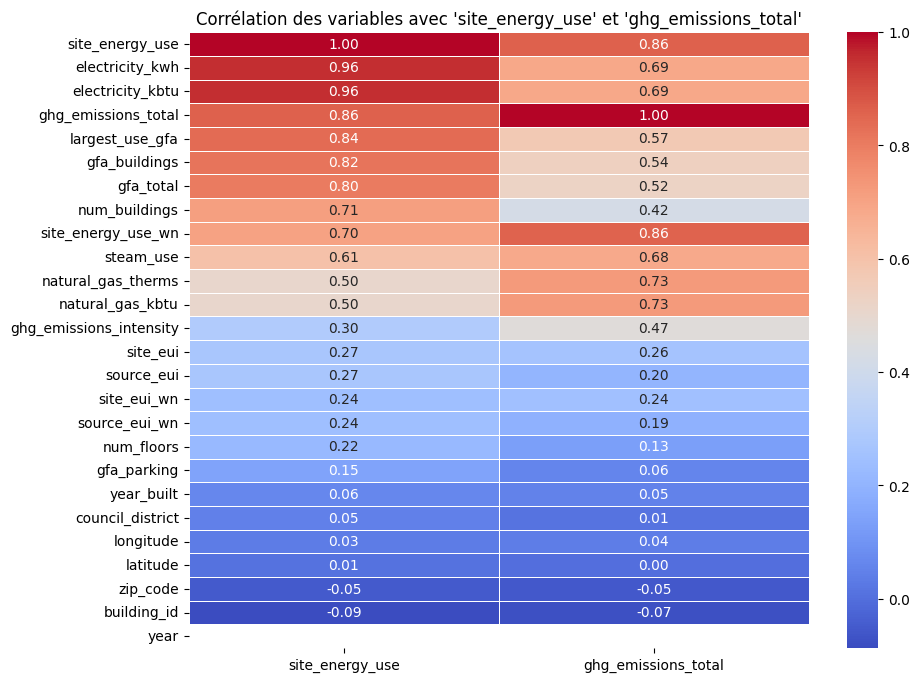

2025-01-31 15:51:14.495 | INFO     | __main__:<module>:38 - ✅ Heatmap affichée avec succès.
2025-01-31 15:51:14.505 | INFO     | __main__:<module>:39 - ============================================================


In [17]:
logger.info("=" * 60)
logger.info("🔍 Analyse des corrélations entre les variables et les cibles ('site_energy_use' & 'ghg_emissions_total')")
logger.info("=" * 60)
# Vérifier que les variables cibles existent dans le dataset
target_cols = ["site_energy_use", "ghg_emissions_total"]
missing_targets = [col for col in target_cols if col not in building_consumption_cleaned.columns]

if missing_targets:
    logger.error(f"❌ Les variables cibles suivantes sont absentes du dataset : {missing_targets}")
    raise ValueError(f"Les variables cibles suivantes sont absentes du dataset : {missing_targets}")

logger.info("✅ Les variables cibles sont présentes dans le dataset.")

# Sélectionner uniquement les variables numériques
logger.info("📊 Sélection des variables numériques...")
numeric_features = building_consumption_cleaned.select_dtypes(include=['number'])

logger.info(f"🔢 Nombre de variables numériques sélectionnées : {numeric_features.shape[1]}")

# Calculer la matrice de corrélation
logger.info("🧮 Calcul de la matrice de corrélation...")
correlation_matrix = numeric_features.corr()

# Extraire uniquement les corrélations des deux cibles et trier correctement
logger.info("📉 Extraction des corrélations avec les variables cibles...")
target_correlation = correlation_matrix[target_cols].sort_values(by="site_energy_use", ascending=False)

logger.info("✅ Matrice de corrélation extraite et triée.")

# Afficher la heatmap des corrélations pour visualiser les différences
logger.info("📊 Affichage de la heatmap des corrélations...")

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Corrélation des variables avec 'site_energy_use' et 'ghg_emissions_total'")
plt.show()

logger.info("✅ Heatmap affichée avec succès.")
logger.info("=" * 60)


In [18]:
logger.info("=" * 60)
# Définition des colonnes à supprimer car trop peu corrélées avec les cibles
low_corr_cols = ["year", "council_district", "longitude", "latitude", "zip_code", "building_id"]

logger.info(f" 🗑 Suppression des colonnes faiblement corrélées : {low_corr_cols}")

# Suppression des colonnes
building_consumption_cleaned.drop(columns=low_corr_cols, inplace=True, errors='ignore')

logger.info(f"✅ Colonnes faiblement corrélées supprimées. Nouveau nombre de colonnes : {building_consumption_cleaned.shape[1]}")
logger.info("=" * 60)

2025-01-31 15:51:14.511 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:14.512 | INFO     | __main__:<module>:5 -  🗑 Suppression des colonnes faiblement corrélées : ['year', 'council_district', 'longitude', 'latitude', 'zip_code', 'building_id']
2025-01-31 15:51:14.514 | INFO     | __main__:<module>:10 - ✅ Colonnes faiblement corrélées supprimées. Nouveau nombre de colonnes : 26
2025-01-31 15:51:14.515 | INFO     | __main__:<module>:11 - ============================================================


In [19]:
logger.info("=" * 60)
# Définition des colonnes redondantes à supprimer
redundant_cols = ["electricity_kwh", "natural_gas_therms", "site_energy_use_wn"]  # On garde 'electricity_kbtu' et 'natural_gas_kbtu'

logger.info(f" 🔄 Suppression des colonnes redondantes : {redundant_cols}")

# Suppression des colonnes redondantes
building_consumption_cleaned.drop(columns=redundant_cols, inplace=True, errors='ignore')

logger.info(f"✅ Colonnes redondantes supprimées. Nouveau nombre de colonnes : {building_consumption_cleaned.shape[1]}")
logger.info("=" * 60)

2025-01-31 15:51:14.521 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:14.522 | INFO     | __main__:<module>:5 -  🔄 Suppression des colonnes redondantes : ['electricity_kwh', 'natural_gas_therms', 'site_energy_use_wn']
2025-01-31 15:51:14.523 | INFO     | __main__:<module>:10 - ✅ Colonnes redondantes supprimées. Nouveau nombre de colonnes : 23
2025-01-31 15:51:14.524 | INFO     | __main__:<module>:11 - ============================================================


In [20]:
logger.info("=" * 60)
logger.info("📊 Vérification finale du dataset après nettoyage...")
logger.info("-" * 20)
logger.info(f"Nombre final de lignes : {building_consumption_cleaned.shape[0]}")
logger.info(f"Nombre final de colonnes : {building_consumption_cleaned.shape[1]}")
logger.info("=" * 60)
# Afficher un aperçu des 5 premières lignes après nettoyage
logger.info("🔍 Aperçu des 5 premières lignes après nettoyage :")
logger.info("=" * 60)
logger.info(f"\n {building_consumption_cleaned.head()}")


2025-01-31 15:51:14.530 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 15:51:14.531 | INFO     | __main__:<module>:2 - 📊 Vérification finale du dataset après nettoyage...
2025-01-31 15:51:14.531 | INFO     | __main__:<module>:3 - --------------------
2025-01-31 15:51:14.532 | INFO     | __main__:<module>:4 - Nombre final de lignes : 1668
2025-01-31 15:51:14.533 | INFO     | __main__:<module>:5 - Nombre final de colonnes : 23
2025-01-31 15:51:14.534 | INFO     | __main__:<module>:6 - ============================================================
2025-01-31 15:51:14.534 | INFO     | __main__:<module>:8 - 🔍 Aperçu des 5 premières lignes après nettoyage :
2025-01-31 15:51:14.535 | INFO     | __main__:<module>:9 - ============================================================
2025-01-31 15:51:14.539 | INFO     | __main__:<module>:10 - 
     building_type property_type neighborhood  year_built  num_buildings  num_floors  gfa_total  gfa_

In [26]:
logger.info("=" * 60)
logger.info("🔍 Début de l'analyse des variables numériques.")
logger.info("=" * 60)

# Définir le chemin du répertoire outputs
output_dir = directories["outputs_dir"]["absolute"]
os.makedirs(output_dir, exist_ok=True)
 
# Liste des variables cibles et explicatives
TARGET_VARS = ["site_energy_use", "ghg_emissions_total"]
other_numerical_columns = [col for col in building_consumption_cleaned.select_dtypes(include=['int64', 'float64']).columns if col not in TARGET_VARS]
numerical_columns = TARGET_VARS + other_numerical_columns  # On place les cibles en premier
categorical_columns = building_consumption_cleaned.select_dtypes(include=['object', 'category']).columns

# Mapping des titres plus explicites
title_mapping = {
    "site_energy_use": "🔋 Consommation énergétique du site",
    "ghg_emissions_total": "🌍 Émissions totales de CO2",
    "year_built": "🏗 Année de construction",
    "num_buildings": "🏢 Nombre de bâtiments",
    "num_floors": "📊 Nombre d'étages",
    "gfa_total": "📏 Surface totale (sqft)",
    "gfa_parking": "🚗 Surface du parking (sqft)",
    "gfa_buildings": "🏠 Surface des bâtiments (sqft)",
    "largest_use_gfa": "🏢 Surface du plus grand usage",
    "site_eui": "⚡ Intensité de l'utilisation de l'énergie (EUI)",
    "site_eui_wn": "🌤 EUI normalisé par la météo",
    "source_eui": "🔌 Source EUI",
    "source_eui_wn": "⛅ Source EUI normalisé",
    "steam_use": "💨 Consommation de vapeur (kBtu)",
    "electricity_kbtu": "⚡ Consommation électrique (kBtu)",
    "natural_gas_kbtu": "🔥 Consommation de gaz naturel (kBtu)",
    "ghg_emissions_intensity": "🌱 Intensité des émissions de CO2"
}

logger.info("-" * 60)
logger.info(f"\U0001F4CA Colonnes numériques détectées : {list(numerical_columns)}")
logger.info("-" * 20)
logger.info(f"\U0001F4D6 Colonnes catégorielles détectées : {list(categorical_columns)}")
logger.info("-" * 60)

html_content = """
<html>
<head>
    <title>Analyse des Variables Numériques</title>
    <style>
        body { font-family: Arial, sans-serif; background-color: #f8f9fa; margin: 20px; font-size: 14px; }
        .container { max-width: 1200px; margin: auto; padding: 20px; }
        h1, h2 { text-align: center; color: #333; }
        h2 { border-bottom: 2px solid #007BFF; padding-bottom: 5px; font-size: 16px; }
        .target { color: #DC3545; font-weight: bold; }
        .grid { display: flex; flex-wrap: wrap; gap: 10px; justify-content: space-between; }
        .image { width: 30%; height: auto; }
        img { width: 100%; height: auto; border-radius: 5px; }
        table { width: 100%; border-collapse: collapse; font-size: 12px; }
        th, td { border: 1px solid #ddd; padding: 6px; text-align: center; }
        th { background-color: #007BFF; color: white; }
        .categorical-grid { display: flex; flex-direction: row; gap: 10px; align-items: center; justify-content: center; }
        .categorical-grid .image { width: 45%; }
        .categorical-grid table { width: 50%; }
    </style>
</head>
<body>
    <div class='container'>
        <h1>📊 Analyse des Variables Numériques</h1>
"""

# Variables cibles et explicatives
target_section = "<h2 class='target'>🎯 Variables Cibles</h2>"
explicative_section = "<h2 class=''>📌 Variables Explicatives</h2>"

for feature in numerical_columns:
    logger.info(f"📌 Analyse en cours pour la colonne : {feature}")
    is_target = feature in TARGET_VARS
    title = title_mapping.get(feature, feature.replace("_", " ").title())
    
    data = building_consumption_cleaned[feature].replace([np.inf, -np.inf], np.nan).dropna()
    
    hist_path = f"{output_dir}/{feature}_histogram.png"
    box_path = f"{output_dir}/{feature}_boxplot.png"
    kde_path = f"{output_dir}/{feature}_kde.png"
    
    plt.figure(figsize=(6, 5))
    sns.histplot(data, bins=30, kde=True, color='blue', alpha=0.75)
    plt.savefig(hist_path)
    plt.close()
    logger.info(f"   📈 Histogramme créé pour {feature}.")

    plt.figure(figsize=(6, 5))
    sns.boxplot(y=data, color='red')
    plt.savefig(box_path)
    plt.close()
    logger.info(f"   📊 Boxplot créé pour {feature}.")

    kde_html = ""
    if len(data) > 1 and len(data.unique()) > 1:
        try:
            kde = gaussian_kde(data)
            x_vals = np.linspace(data.min(), data.max(), 100)
            y_vals = kde(x_vals)
            plt.figure(figsize=(6, 5))
            plt.plot(x_vals, y_vals, color='red')
            plt.savefig(kde_path)
            plt.close()
            kde_html = f"<div class='image'><img src='{kde_path}'></div>"
            logger.info(f"  📉 KDE ajoutée pour {feature}.")
        except np.linalg.LinAlgError:
            kde_html = ""
            logger.warning(f"   ⚠️ Impossible de calculer la KDE pour {feature}.")

    
    stats = data.describe().to_frame().reset_index()
    stats_html = stats.to_html(index=False, escape=False, border=1)
    logger.info(f"  📊 Tableau des statistiques créé pour {feature}.")

    section_content = f"""
    <h2 class='{'target' if is_target else ''}'>{title}</h2>
    <div class='grid'>
        <div class='image'><img src='{hist_path}'></div>
        <div class='image'><img src='{box_path}'></div>
        {kde_html}
        <div class='image'>{stats_html}</div>
    </div>
    """

    if is_target:
        target_section += section_content
    else:
        explicative_section += section_content

html_content += target_section + explicative_section
html_content += "</div></body></html>"

 
    
# Analyse des variables catégorielles
html_content += "<h1>📑 Analyse des Variables Catégorielles</h1>"
for feature in categorical_columns:
    logger.info(f"📌 Analyse en cours pour la colonne catégorielle : {feature}")

    value_counts = building_consumption_cleaned[feature].value_counts()

    # Graphique en barres
    bar_path = os.path.join(output_dir, f"{feature}_barplot.png")
    plt.figure(figsize=(6, 4))
    sns.barplot(x=value_counts.values, y=value_counts.index, palette="Blues_r")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel("Catégories")
    plt.title(f"Distribution de {feature}")
    plt.savefig(bar_path, bbox_inches='tight')
    plt.close()

    # Tableau des statistiques
    stats_html = value_counts.to_frame().reset_index().to_html(index=False, escape=False, border=1)

    html_content += f"""
    <h2>{feature}</h2>
    <div class='categorical-grid'>
        <div class='image'><img src='{bar_path}'></div>
        <div class='image'>{stats_html}</div>
    </div>
    """

html_content += "</div></body></html>"

# Sauvegarde du fichier HTML
html_path = os.path.join(output_dir, "analyse_numerique.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_content)

logger.info(f"✅ Rapport HTML généré avec succès : {html_path}")
logger.info("🎯 Fin de l'analyse des colonnes numériques.")
logger.info("=" * 60)

2025-01-31 16:08:40.878 | INFO     | __main__:<module>:1 - ============================================================
2025-01-31 16:08:40.878 | INFO     | __main__:<module>:2 - 🔍 Début de l'analyse des variables numériques.
2025-01-31 16:08:40.879 | INFO     | __main__:<module>:3 - ============================================================
2025-01-31 16:08:40.882 | INFO     | __main__:<module>:36 - ------------------------------------------------------------
2025-01-31 16:08:40.883 | INFO     | __main__:<module>:37 - 📊 Colonnes numériques détectées : ['site_energy_use', 'ghg_emissions_total', 'year_built', 'num_buildings', 'num_floors', 'gfa_total', 'gfa_parking', 'gfa_buildings', 'largest_use_gfa', 'site_eui', 'site_eui_wn', 'source_eui', 'source_eui_wn', 'steam_use', 'electricity_kbtu', 'natural_gas_kbtu', 'ghg_emissions_intensity']
2025-01-31 16:08:40.884 | INFO     | __main__:<module>:38 - --------------------
2025-01-31 16:08:40.885 | INFO     | __main__:<module>:39 - 📖 Colonn